<a href="https://colab.research.google.com/github/C-Little26/ECGR4105/blob/main/Hw6/ECGR4105_Hw6_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#necessary libraries
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time

from torchvision import datasets
from torchvision import transforms

In [2]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 34648736.21it/s]


Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified


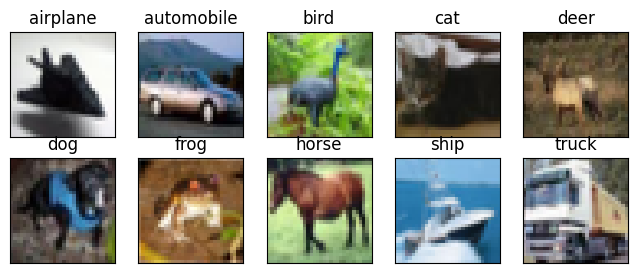

In [3]:
# Code from dlwpt repository
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

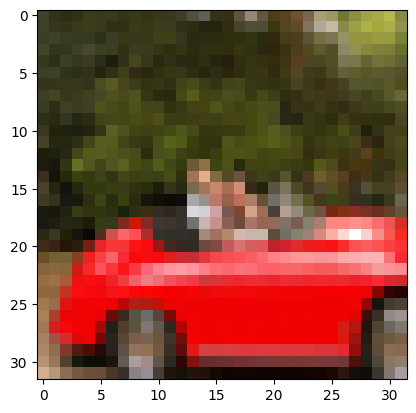

In [4]:
img, label = cifar10[99]
img, label, class_names[label]
plt.imshow(img)

In [5]:
#transform img to tensor
toTensor = transforms.ToTensor()
img_t = toTensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [6]:
#convert rest of dataset to tensors
cifar10_t = datasets.CIFAR10(data_path, train=True, download = False, transform = transforms.ToTensor())

In [7]:
#normalize data
imgs = torch.stack([img_t for img_t, _ in cifar10_t], dim=3)
#use these values for normalizing data
print(imgs.view(3, -1).mean(dim=1))
print(imgs.view(3, -1).std(dim=1))
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470,0.2435,0.2616))
c10_tran = datasets.CIFAR10(data_path, train=True, download=False,
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470,0.2435,0.2616))]))
c10_tran_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470,0.2435,0.2616))]))

c10_tran

tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data-unversioned/p1ch7/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )

In [8]:
#Problem 2a
#create a neural network with 1 hidden layer of size 512
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

n_out = 10
model = nn.Sequential(nn.Linear(3072, 512), nn.ReLU(), nn.Linear(512, n_out), nn.LogSoftmax(dim=1))

In [20]:
#declare whether to use gpu or cpu for operations
device = torch.device('cuda')
#device = torch.device('cpu')
print(device)

cuda


In [10]:
train_loader = torch.utils.data.DataLoader(c10_tran, batch_size=64, shuffle=True)

In [11]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.NLLLoss()
n_epochs = 100
losses = []

In [12]:
#run training
start_time = time.time() #time training starts
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(float(loss))
    if epoch %10 == 0 or epoch == 100:
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
end_time = time.time()
train_time = end_time - start_time
print("Training Time:", train_time, "seconds")

Epoch: 0, Loss: 8.423181
Epoch: 10, Loss: 8.449201
Epoch: 20, Loss: 5.352820
Epoch: 30, Loss: 7.447827
Epoch: 40, Loss: 3.197500
Epoch: 50, Loss: 3.147374
Epoch: 60, Loss: 5.663279
Epoch: 70, Loss: 3.016705
Epoch: 80, Loss: 4.624740
Epoch: 90, Loss: 3.744116
Training Time: 1358.9843003749847 seconds


In [13]:
# Training Accuracy
train_loader = torch.utils.data.DataLoader(c10_tran, batch_size=64, shuffle=False)
train_correct = 0
train_total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        train_total += labels.shape[0]
        train_correct += int((predicted == labels).sum())

print("Training Accuracy: %f" % (train_correct / train_total))

# Validation Accuracy
val_loader = torch.utils.data.DataLoader(c10_tran_val, batch_size=64,shuffle=False)
val_correct = 0
val_total = 0

val_loss = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        val_total += labels.shape[0]
        val_correct += int((predicted == labels).sum())

print("Validation Accuracy: %f" % (val_correct / val_total))

Training Accuracy: 0.405400
Validation Accuracy: 0.317300


In [14]:
# Save Model
torch.save(model.state_dict(), 'CIFAR10_1Layer.pt')

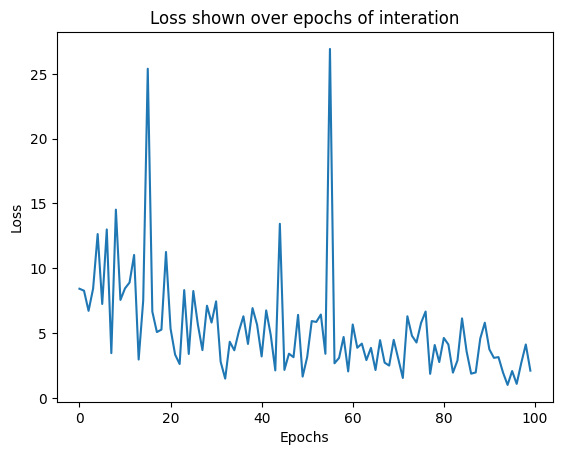

In [15]:
# Plot Loss over epochs
plt.figure(1)
plt.plot(range(n_epochs), losses)
plt.title("Loss shown over epochs of interation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [16]:
model_b = nn.Sequential(
     nn.Linear(3072, 1024),
     nn.ReLU(),
     nn.Linear(1024, 512),
     nn.ReLU(),
     nn.Linear(512, 128),
     nn.ReLU(),
     nn.Linear(128, 10)) #step down the layers using values of 2^n
model_b

Sequential(
  (0): Linear(in_features=3072, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
#reestablish the trainer
train_loader_b = torch.utils.data.DataLoader(c10_tran, batch_size=64, shuffle=True)

In [18]:
#declare all remaining variables before training
model_b = model_b.to(device)
optimizer_b = optim.SGD(model_b.parameters(), lr=1e-3)
loss_fn_b = nn.CrossEntropyLoss()
n_epochs = 300


losses_b = []

In [19]:
start_time = time.time() #records what time the training starts
for epoch in range(n_epochs):
    for imgs, labels in train_loader_b:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model_b(imgs.view(imgs.shape[0], -1))
        loss = loss_fn_b(outputs, labels)

        optimizer_b.zero_grad()
        loss.backward()
        optimizer_b.step()

    losses_b.append(float(loss))
    if epoch %10 == 0 or epoch == 300:
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
end_time = time.time()
train_time = end_time - start_time
print("Training Time:", train_time, "seconds")

Epoch: 0, Loss: 2.294612
Epoch: 10, Loss: 1.926276
Epoch: 20, Loss: 1.461812
Epoch: 30, Loss: 1.902502
Epoch: 40, Loss: 1.346269
Epoch: 50, Loss: 1.259459
Epoch: 60, Loss: 1.193187
Epoch: 70, Loss: 0.919044
Epoch: 80, Loss: 0.694530
Epoch: 90, Loss: 0.435248
Epoch: 100, Loss: 0.410485
Epoch: 110, Loss: 0.554864
Epoch: 120, Loss: 0.275531
Epoch: 130, Loss: 0.228137
Epoch: 140, Loss: 0.176073
Epoch: 150, Loss: 0.211067
Epoch: 160, Loss: 0.225125
Epoch: 170, Loss: 0.055012
Epoch: 180, Loss: 0.056270
Epoch: 190, Loss: 0.069968
Epoch: 200, Loss: 0.010014
Epoch: 210, Loss: 0.037265
Epoch: 220, Loss: 0.032980
Epoch: 230, Loss: 0.020889
Epoch: 240, Loss: 0.011437
Epoch: 250, Loss: 0.034616
Epoch: 260, Loss: 0.026420
Epoch: 270, Loss: 0.004700
Epoch: 280, Loss: 0.006927
Epoch: 290, Loss: 0.003612
Training Time: 4273.270942687988 seconds


In [24]:
# Training Accuracy
train_loader = torch.utils.data.DataLoader(c10_tran, batch_size=64, shuffle=False)
train_correct = 0
train_total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_b(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        train_total += labels.shape[0]
        train_correct += int((predicted == labels).sum())

print("Training Accuracy: %f" % (train_correct / train_total))

# Validation Accuracy
val_loader = torch.utils.data.DataLoader(c10_tran_val, batch_size=64, shuffle=False)
val_correct = 0
val_total = 0

val_loss_b = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_b(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        val_total += labels.shape[0]
        val_correct += int((predicted == labels).sum())

print("Validation Accuracy: %f" % (val_correct / val_total))

Training Accuracy: 1.000000
Validation Accuracy: 0.524000


In [25]:
# Save Model
torch.save(model_b.state_dict(), 'CIFAR10_3Layer.pt')

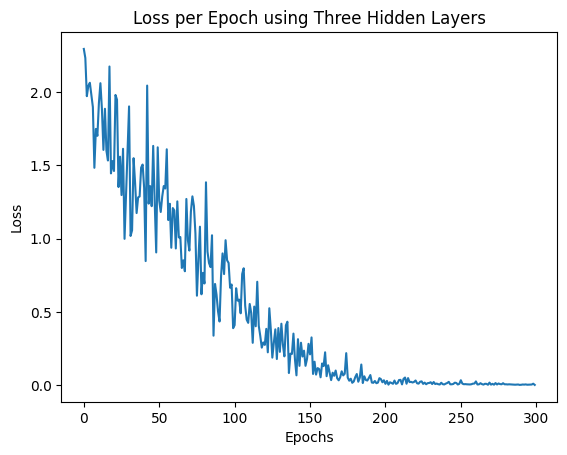

In [26]:
# Plot Loss over epochs
plt.figure(1)
plt.plot(range(n_epochs), losses_b)
plt.title("Loss per Epoch using Three Hidden Layers")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()